# Introduction

Update : 2018-09-11   
This kernel is what I wrote method of time series analysis that I know.  
Please let me know if I make any mistakes.

The order of explain is as follows.
1. Overview of the data
2. Model choice
3. Correlograms
4. ARIMA
5. SARIMA
6. Make featrues1
7. ARIMAX
8. SARIMAX
9. Model's summary check
10. Make featrues2
11. Search best parameters
12. Submit Prediction 

Referenced documents:
-  [http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels](http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels) 

# modules import

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm

# data-set reading

In [2]:
train = pd.read_csv('train.csv' ,parse_dates=['date'],index_col='date')#('../input/train.csv' ,parse_dates=['date'],index_col='date')
test = pd.read_csv('test.csv', parse_dates=['date'],index_col='date')#('../input/test.csv', parse_dates=['date'],index_col='date')
df = pd.concat([train,test],sort=True)
sample = pd.read_csv('sample_submission.csv')#('../input/sample_submission.csv')

We use item1_store1_sales time series in this kernel.

In [3]:
buf = df[(df.item==1)&(df.store==1)].copy()

# Overview of the data.

Let's see overview of the data.  
We can use seasonal_decompose method to separate into four graphs(Observed,Trend,Seasonal,Residual).  
What is seasonal_decompose method parameter 'freq'?
- freq = 365 : trend of year.  
- freq = 30 : trend of month.  
- freq = 7 : trend of week.  

We choose 'freq=365' ,because this data is long term.

findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


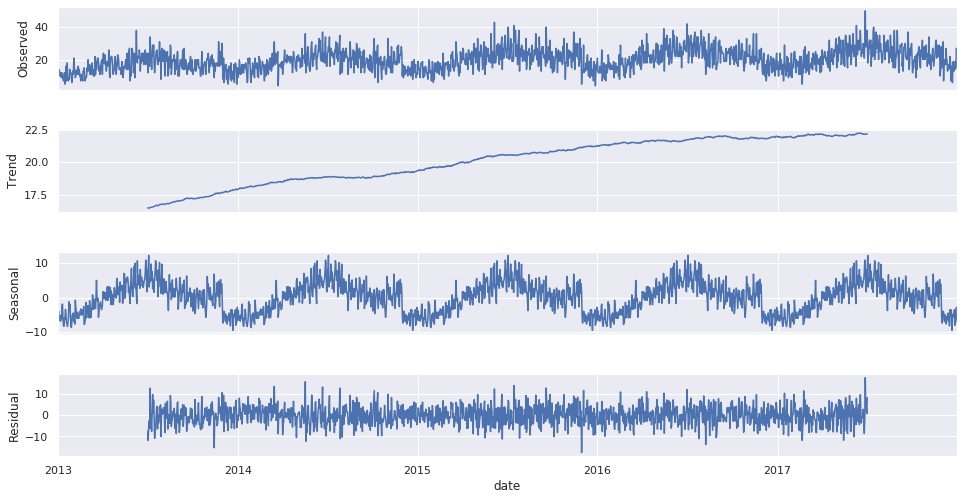

In [4]:
res = sm.tsa.seasonal_decompose(buf.sales.dropna(),freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

Clearly,this data is growing(has a trend).

# Train & Test Data split

In [5]:
#train_test_split
tr_start,tr_end = '2014-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()

each models have parameters.
- ARMA model:(p,q)
- ARIMA model:(p,d,q)
- SARIMA model:(p,d,q)(sp,sd,sq,s)
- ARIMAX model:(p,d,q) + exog
- SARIMAX model:(p,d,q)(sp,sd,sq,s) +exog

# Model choice

We have to choice a model, After we comfirm that a data has a trend(is stationary) or not.  
For example, ARMA model is premised that the data is stationary.

We can use ADF-test to check stationary of the data.

In [6]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(buf['sales'].dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.0761068899241545


In [7]:
#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(buf['sales'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:1.2109276320440464e-23


It's important to choose carefully a period of the data which will be used in predicting. Because, The results depend on the period.

In [8]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(buf['sales']['2015-01-01':].dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.5620643402531433


In [9]:
#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(buf['sales']['2015-01-01':].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:4.530417561582162e-22


What is adfuller method parameter 'regression'?
- ’c’ : constant only (default)
- ’ct’ : constant and trend
- ’ctt’ : constant, and linear and quadratic trend
- ’nc’ : no constant, no trend

[https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) 


Usually,　We try to testing　both data Original and Diff.  
Like the results above, When Original-data is not stationary and Diff-data is stationary,the time series is called unit root process.  
For unit root process, We use ARIMA or SARIMA model.

From results,We decided that Original time series is not stational.    
We will try to using ARIMA model.

# Correlograms

Autocorrelogram & Partail Autocorrelogram is useful that to estimate each models parametaers.

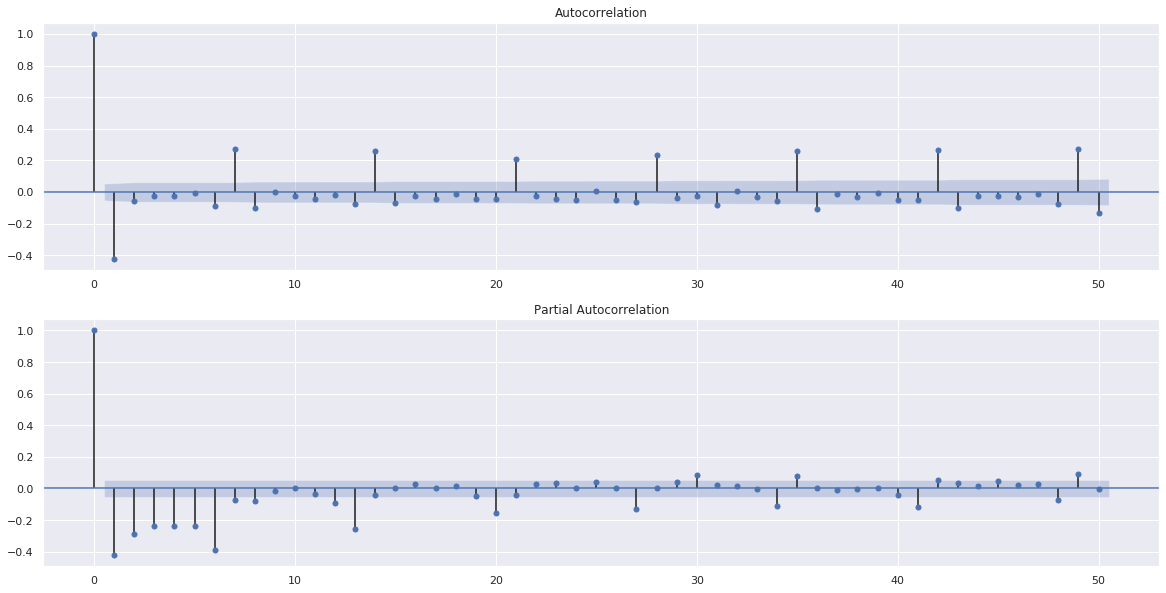

In [10]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(tra.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(tra.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From results,looks like ARIMA(p=7,d=1,q=?) model.

if we use arma_order_select_ic method, it is very easy to search best parameters(p,q) of ARMA model.

In [11]:
resDiff = sm.tsa.arma_order_select_ic(tra, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available

ARMA(p,q) = (7, 7) is the best.


C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


We got parameters (7,1,7).

# ARIMA model

In [12]:
arima = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),freq='D',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .

C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1369
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -4068.725
Date:                Wed, 31 Jul 2019   AIC                           8167.450
Time:                        11:12:16   BIC                           8245.679
Sample:                    01-01-2014   HQIC                          8196.736
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8964      0.036    -24.661      0.000      -0.968      -0.825
ar.L2         -0.8996      0.036    -24.873      0.000      -0.970      -0.829
ar.L3         -0.8962      0.036    -24.846      0.000      -0.967      -0.825
ar.L4         -0.8918      0.036    -24.596      0.000      -0.963      -0.821
ar.L5         -0.8973      0.035    -25.647      0.000      -0.966      -0.829
ar.L6         -0.8920      0.036    -24.787      0.000      -0.963      -0.821
ar.L7          0.0986      0.035      2.811      0.005       0.030       0.167
ma.L1          0.0562      0.022      2.575      0.010       0.013       0.099
ma.L2          0.0981      0.020      4.823      0.000       0.058       0.138
ma.L3          0.0361      0.021      1.716      0.086      -0.005       0.077
ma.L4          0.0550      0.020      2.720      0.007       0.015       0.095
ma.L5          0.0963      0.020      4.794      0.000       0.057       0.136
ma.L6          0.0759      0.021      3.594      0.000       0.035       0.117
ma.L7         -0.8595      0.019    -45.425      0.000      -0.897      -0.822
sigma2        24.6885      0.995     24.806      0.000      22.738      26.639
===================================================================================
Ljung-Box (Q):                       46.42   Jarque-Bera (JB):                 9.97
Prob(Q):                              0.22   Prob(JB):                         0.01
Heteroskedasticity (H):               1.34   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This model's resid have few autocorrelation.  
It means that We were able to make a good model.

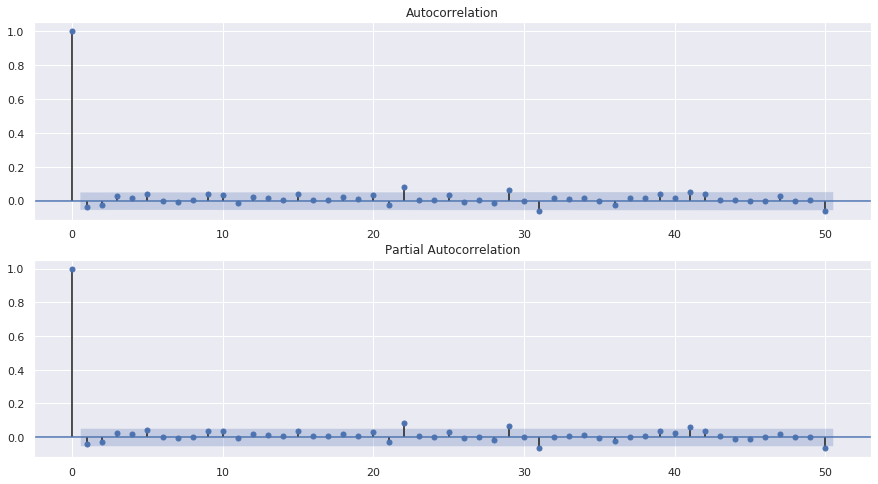

In [13]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
pred = arima.predict(tr_end,te_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMA model MSE:45.04681987837244


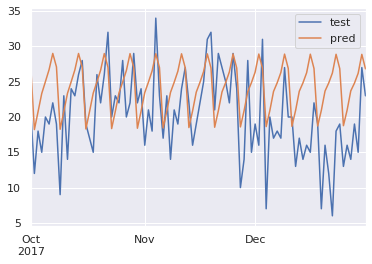

In [15]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

# SARIMA model

 I don't know the best way to estimate seasonal_order(sp,sd,sq,s) parameters.  
parameter s:
- 1 for yearly
- 4 for quarterly
- 12 for monthly
- 52 for weekly
- 365 for daily 

[https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) 

When we choose period 365,It will run out of memory.  
It will probably, SARIMA model is unsuitable to solve this problem.  
[Forecasting with long seasonal periods(for R)](https://robjhyndman.com/hyndsight/longseasonality/)  
[Deciding the value of period in seasonal ARIMA (for R)](https://stats.stackexchange.com/questions/225995/deciding-the-value-of-period-in-seasonal-arima-r)  

For now,we choose period 1.

In [16]:
sarima = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(7,1,7,1),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarima.summary()

C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1369
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 1)   Log Likelihood               -4068.496
Date:                           Wed, 31 Jul 2019   AIC                           8194.992
Time:                                   11:12:59   BIC                           8346.063
Sample:                               01-01-2014   HQIC                          8251.564
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9085      0.619     -1.468      0.142      -2.122       0.305
ar.L2         -0.8970      0.621     -1.444      0.149      -2.114       0.320
ar.L3         -0.8838      0.612     -1.444      0.149      -2.084       0.316
ar.L4         -0.8767      0.596     -1.472      0.141      -2.044       0.291
ar.L5         -0.8901      0.584     -1.523      0.128      -2.036       0.255
ar.L6         -0.8987      0.590     -1.523      0.128      -2.055       0.258
ar.L7          0.0859      0.601      0.143      0.886      -1.092       1.264
ma.L1         -0.0843      0.025     -3.353      0.001      -0.134      -0.035
ma.L2         -0.0707      0.024     -2.922      0.003      -0.118      -0.023
ma.L3         -0.0574      0.028     -2.079      0.038      -0.111      -0.003
ma.L4         -0.0667      0.027     -2.493      0.013      -0.119      -0.014
ma.L5         -0.0025      0.026     -0.098      0.922      -0.053       0.048
ma.L6         -0.0431      0.028     -1.557      0.119      -0.097       0.011
ma.L7         -0.9409      0.026    -36.277      0.000      -0.992      -0.890
ar.S.L1       -0.9111      0.619     -1.471      0.141      -2.125       0.303
ar.S.L2       -0.8582      0.604     -1.420      0.156      -2.043       0.326
ar.S.L3       -0.9025      0.554     -1.628      0.104      -1.989       0.184
ar.S.L4       -0.8725      0.571     -1.527      0.127      -1.992       0.247
ar.S.L5       -0.8998      0.540     -1.666      0.096      -1.958       0.159
ar.S.L6       -0.8457      0.565     -1.498      0.134      -1.952       0.261
ar.S.L7        0.0240      0.534      0.045      0.964      -1.023       1.071
ma.S.L1       -0.0843      0.025     -3.353      0.001      -0.134      -0.035
ma.S.L2       -0.0707      0.024     -2.922      0.003      -0.118      -0.023
ma.S.L3       -0.0574      0.028     -2.079      0.038      -0.111      -0.003
ma.S.L4       -0.0667      0.027     -2.493      0.013      -0.119      -0.014
ma.S.L5       -0.0025      0.026     -0.098      0.922      -0.053       0.048
ma.S.L6       -0.0431      0.028     -1.557      0.119      -0.097       0.011
ma.S.L7       -0.9409      0.026    -36.277      0.000      -0.992      -0.890
sigma2        20.1012      0.846     23.755      0.000      18.443      21.760
===================================================================================
Ljung-Box (Q):                       43.77   Jarque-Bera (JB):                 7.21
Prob(Q):                              0.31   Prob(JB):                         0.03
Heteroskedasticity (H):               1.37   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covarianc

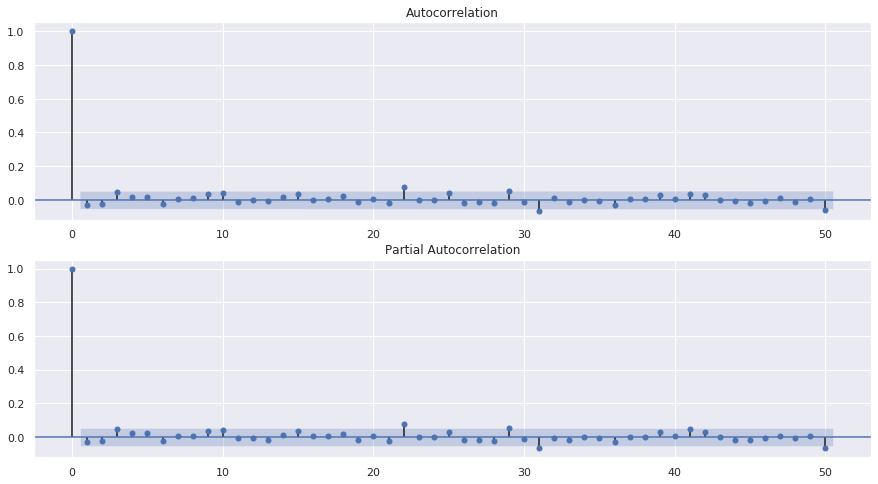

In [17]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

SARIMA model MSE:27.859167818993303


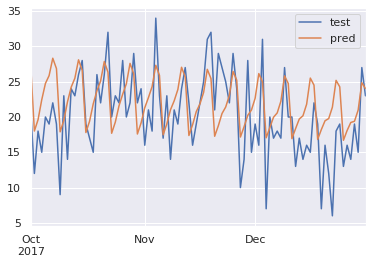

In [19]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

It seems that SARIMA model's prediction is better than ARIMA model's.

Next,We try to ARIMAX and SARIMAX model.  
ARIMAX(SARIMAX) is what added  exogenous regressors to ARIMA(SARIMA) .

# Make features1

Let's try to make some features.
- month
- dayofweek
- sales_shifted_364(1year_shift)
- sales_shifted_728(2year_shift)

Sales gropu by month

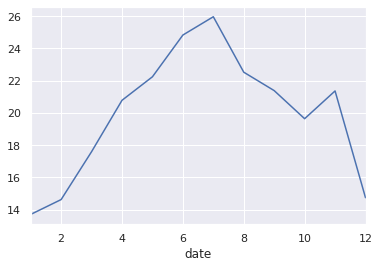

In [20]:
buf.groupby(buf.index.month).sales.mean().plot();plt.show()

Sales gropu by day of the week.

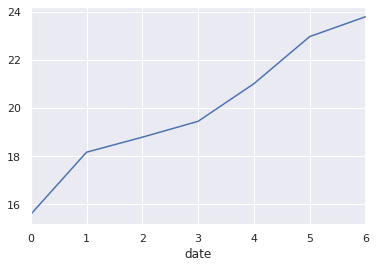

In [21]:
buf.groupby(buf.index.weekday).sales.mean().plot();plt.show()

The two data looks like the same.

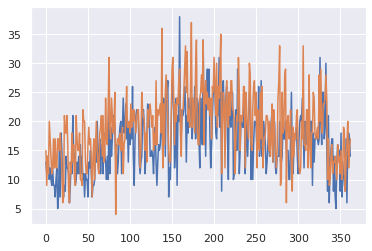

In [22]:
plt.plot(buf[0:363].sales.dropna().values)
plt.plot(buf[364:727].sales.dropna().values);plt.show()

In [23]:
buf = df[(df.item==1)&(df.store==1)].copy()#reset buf
#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
buf = pd.concat([buf, month_dummies], axis=1, join_axes=[buf.index]).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
buf = pd.concat([buf, week_dummies], axis=1, join_axes=[buf.index]).drop(['dayofweek'],axis=1)
#Satday,Sunday
buf['weekend'] = (buf.index.dayofweek>4).astype(int)#Satday,Sunday
#Sunday
#buf['sunday'] = (buf.index.dayofweek==6).astype(int)#Satday,Sunday

In [24]:
#shifted data
#buf['sales_shifted_91'] = buf.sales.shift(91)
buf['sales_shifted_728'] = buf.sales.shift(728)
buf['sales_shifted_364'] = buf.sales.shift(364)

In [25]:
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()
exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = buf.drop(['id','store','item','sales'],axis = 1)[te_start:te_end].dropna()

# ARIMAX model

In [26]:
arimax = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimax.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .

C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -2956.757
Date:                Wed, 31 Jul 2019   AIC                           5987.513
Time:                        11:13:24   BIC                           6168.915
Sample:                    01-01-2015   HQIC                          6056.475
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -3.7941      1.120     -3.387      0.001      -5.990      -1.598
month-2              -3.4582      1.077     -3.210      0.001      -5.569      -1.347
month-3              -2.0306      0.972     -2.090      0.037      -3.935      -0.126
month-4              -0.5244      0.857     -0.612      0.541      -2.204       1.155
month-5               0.2593      0.930      0.279      0.780      -1.563       2.082
month-6               1.4108      1.005      1.404      0.160      -0.559       3.381
month-7               2.9981      1.087      2.757      0.006       0.867       5.129
month-8               1.4094      0.961      1.467      0.142      -0.474       3.293
month-9               2.9985      0.878      3.414      0.001       1.277       4.720
month-10              2.6642      1.041      2.559      0.011       0.623       4.705
month-11              2.0736      1.105      1.877      0.061      -0.092       4.239
month-12             -4.0067      1.102     -3.636      0.000      -6.167      -1.847
dayofweek-0          -3.5743      0.459     -7.789      0.000      -4.474      -2.675
dayofweek-1          -0.7535      0.405     -1.860      0.063      -1.547       0.040
dayofweek-2          -0.3644      0.371     -0.982      0.326      -1.092       0.363
dayofweek-3           0.1881      0.396      0.475      0.635      -0.588       0.965
dayofweek-4           1.7115      0.374      4.572      0.000       0.978       2.445
dayofweek-5           1.0844      0.296      3.659      0.000       0.503       1.665
dayofweek-6           1.7079      0.324      5.267      0.000       1.072       2.343
weekend               2.7924      0.238     11.713      0.000       2.325       3.260
sales_shifted_728     0.0329      0.036      0.918      0.359      -0.037       0.103
sales_shifted_364     0.0560      0.034      1.637      0.102      -0.011       0.123
ar.L1                -0.3114      3.743     -0.083      0.934      -7.648       7.026
ar.L2                 0.6184      0.892      0.693      0.488      -1.130       2.366
ar.L3                -0.0857      1.692     -0.051      0.960      -3.403       3.231
ar.L4                -0.3171      1.075     -0.295      0.768      -2.424       1.790
ar.L5                 0.2547      0.599      0.425      0.671      -0.920       1.429
ar.L6                 0.1007      1.388      0.073      0.942      -2.619       2.821
ar.L7                -0.0316      0.157     -0.201      0.841      -0.340       0.277
ma.L1                -0.8481      3.552     -0.239      0.811      -7.810       6.113
ma.L2                -1.0228      4.317     -0.237      0.813      -9.484       7.439
ma.L3                 0.8246      1.926      0.428      0.669      -2.951       4.600
ma.L4                 0.2798      2.820      0.099      0.921      -5.247       5.806
ma.L5                -0.5743      1.098     -0.523      0.601      -2.727       1.578
ma.L6                 0.1282      1.557      0.082      0.9

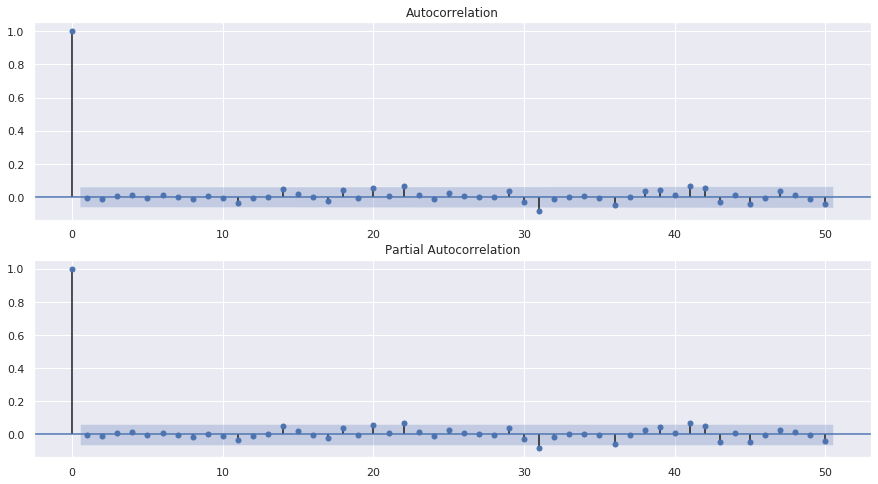

In [27]:
res = arimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
pred = arimax.predict(tr_end,te_end,exog = exog_test)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX model MSE:23.3684186666455


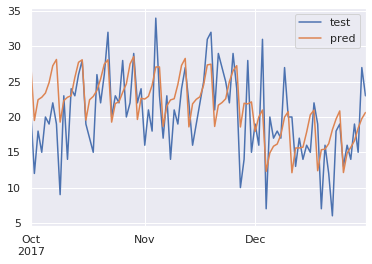

In [29]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

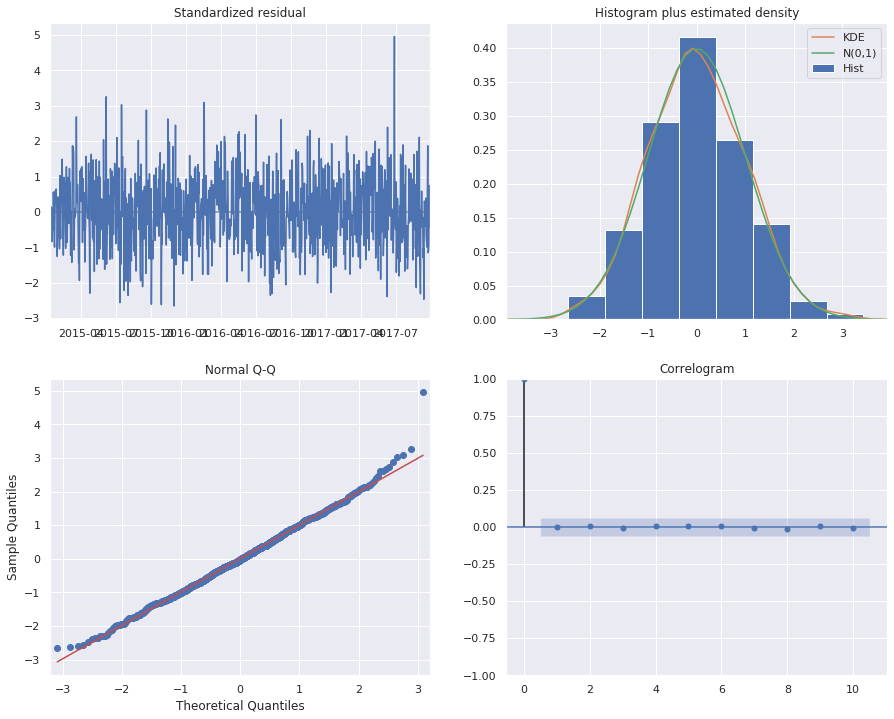

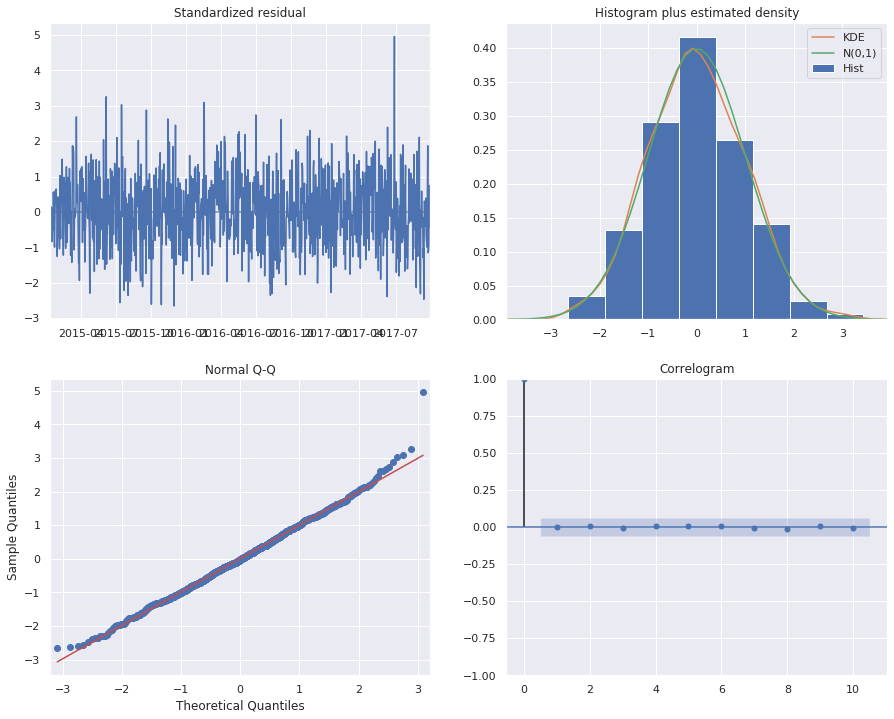

In [30]:
arimax.plot_diagnostics(figsize=(15, 12))

# SARIMAX model

In [31]:
sarimax = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(1,0,5,1),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarimax.summary()

C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1004
Model:             SARIMAX(7, 1, 7)x(1, 0, 5, 1)   Log Likelihood               -2949.045
Date:                           Wed, 31 Jul 2019   AIC                           5984.091
Time:                                   11:14:02   BIC                           6194.692
Sample:                               01-01-2015   HQIC                          6064.173
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -3.4792      1.215     -2.863      0.004      -5.861      -1.097
month-2              -3.5069      1.162     -3.019      0.003      -5.783      -1.230
month-3              -1.9734      1.067     -1.849      0.064      -4.065       0.118
month-4              -0.4308      0.963     -0.447      0.655      -2.318       1.456
month-5              -0.1082      1.035     -0.105      0.917      -2.137       1.921
month-6               1.2486      1.063      1.174      0.240      -0.835       3.332
month-7               2.8573      1.128      2.532      0.011       0.646       5.069
month-8               1.3680      1.008      1.357      0.175      -0.608       3.344
month-9               3.1271      0.972      3.217      0.001       1.222       5.032
month-10              3.2155      1.185      2.713      0.007       0.893       5.538
month-11              1.7469      1.218      1.434      0.152      -0.641       4.135
month-12             -4.0648      1.209     -3.362      0.001      -6.434      -1.695
dayofweek-0          -3.6715      0.458     -8.012      0.000      -4.570      -2.773
dayofweek-1          -0.5155      0.390     -1.322      0.186      -1.280       0.249
dayofweek-2          -0.3299      0.358     -0.922      0.356      -1.031       0.371
dayofweek-3           0.1582      0.382      0.414      0.679      -0.590       0.907
dayofweek-4           1.6579      0.367      4.517      0.000       0.939       2.377
dayofweek-5           1.0235      0.282      3.625      0.000       0.470       1.577
dayofweek-6           1.6772      0.309      5.432      0.000       1.072       2.282
weekend               2.7007      0.242     11.169      0.000       2.227       3.175
sales_shifted_728     0.0410      0.037      1.104      0.269      -0.032       0.114
sales_shifted_364     0.0661      0.036      1.861      0.063      -0.004       0.136
ar.L1                 0.0774      3.195      0.024      0.981      -6.185       6.340
ar.L2                -0.8928      3.441     -0.259      0.795      -7.637       5.851
ar.L3                 0.0850      5.703      0.015      0.988     -11.093      11.262
ar.L4                 0.3897      5.793      0.067      0.946     -10.964      11.744
ar.L5                -0.3580      4.198     -0.085      0.932      -8.585       7.869
ar.L6                 0.3552      2.388      0.149      0.882      -4.325       5.035
ar.L7                -0.2721      1.398     -0.195      0.846      -3.011       2.467
ma.L1                -0.4349      3.924     -0.111      0.912      -8.125       7.256
ma.L2                -0.1819      1.434     -0.127      0.899      -2.992       2.628
ma.L3                -0.0818      1.697     -0.048      0.962      -3.407       3.244
ma.L4                -0.6672      1.266     -0.527      0.598      -3.148       1.813
ma.L5                 0.4351      2.850      0

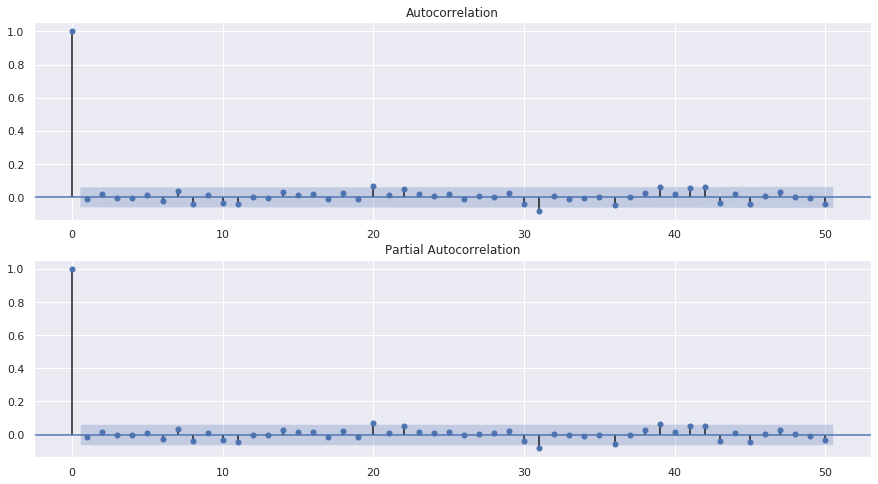

In [32]:
res = sarimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
pred = sarimax.predict(tr_end,te_end,exog = exog_test)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

SARIMAX model MSE:24.137100850540538


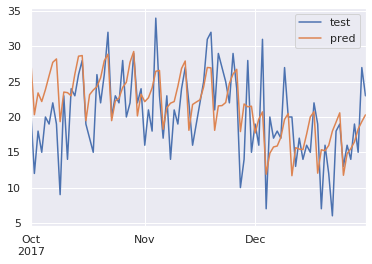

In [34]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

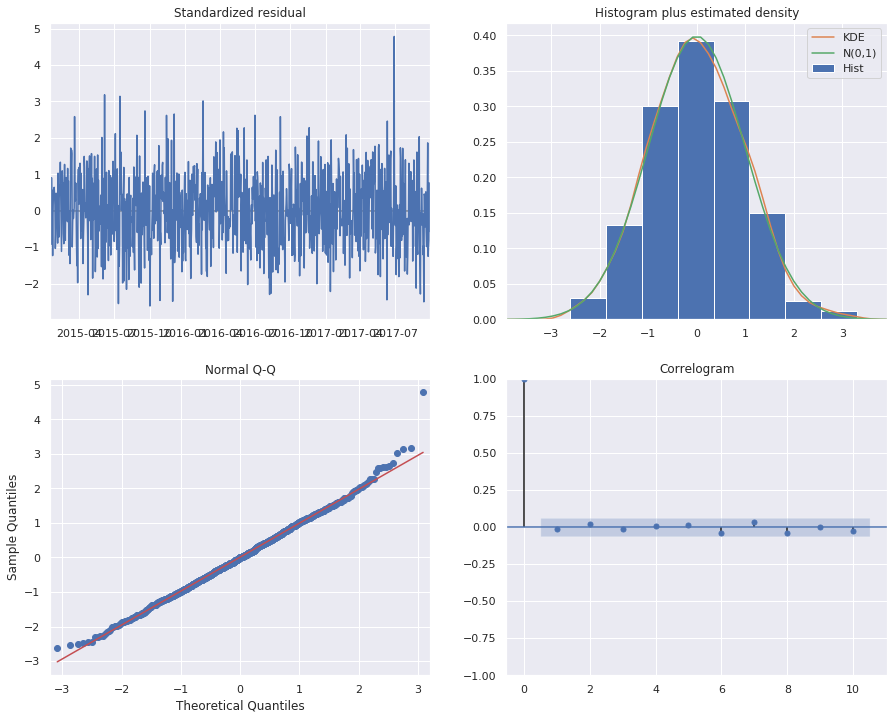

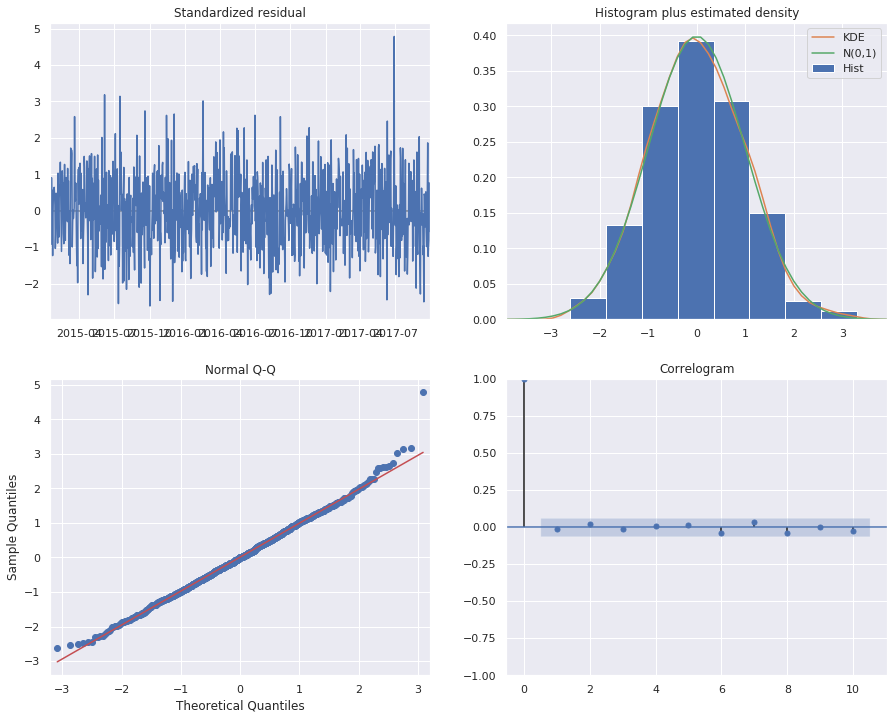

In [35]:
sarimax.plot_diagnostics(figsize=(15, 12))

It seems that ARIMAX model's prediction is better than SARIMAX model's.  
And  because SARIMA(X) model has a issue(seasonal period parameter),we choose ARIMAX model.

# ARIMAX Model's summary check

The results of Jarque-Bera test and Ljung-Box test provide an indication of the validity of this model.
 
 In this model's summary, Jarque-Bera test's Prob is under 0.05.  
 It means that this model's resid is not following a normal distribution.  
 In other words, some infomations still remain in this model's resid.  
 
Look at the histgram which was output by plot_diagnostics method,
It looks like slightly skew.

Ljung-Box test:
[https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test)

Jarque-Bera test:
[https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test)

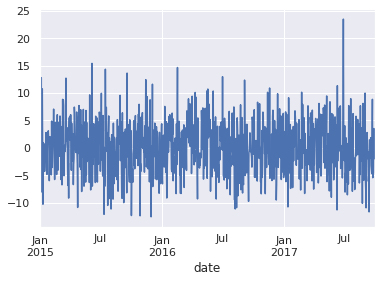

In [36]:
arimax.resid.plot();plt.show()

It seems that there is outlier in this model's resid on late June.

In [37]:
res_df = pd.DataFrame(arimax.resid,columns=['resid'])
res_df.sort_values(by='resid',ascending=False).head(5)

,resid
date,
2017-06-28,23.498620
2015-06-06,15.425074
2016-02-17,14.671327
2015-07-16,14.356358
2015-09-19,13.650476


The outlier is the sales in '2017-06-28'.  
Is the date an anniversary or something?

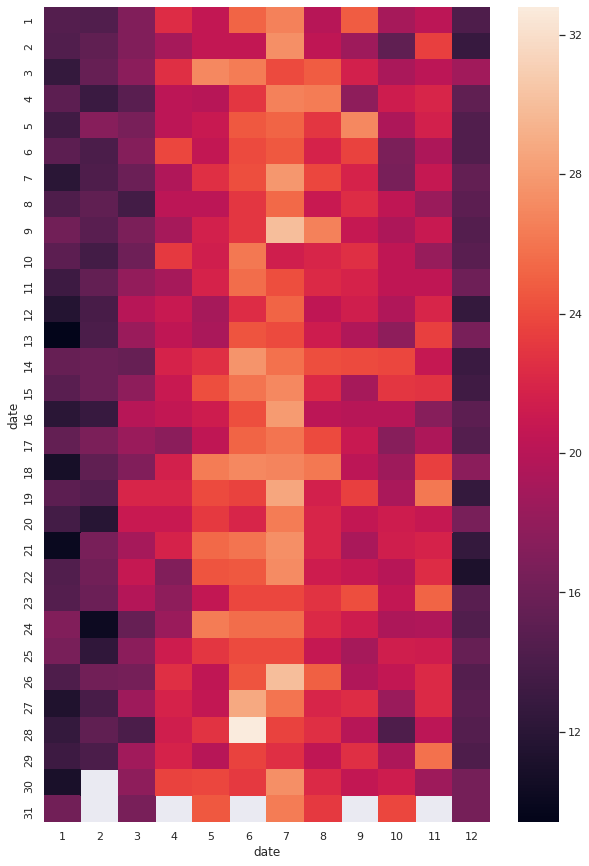

In [38]:
plt.figure(figsize=(10,15))
piv_val = buf.pivot_table(values='sales',
                          index=buf.index.day,
                          columns=buf.index.month,
                          aggfunc='mean')
sns.heatmap(piv_val)
plt.show()

In [39]:
buf[(buf.index.day == 28)&(buf.index.month == 6)]['sales']

date
2013-06-28    17.0
2014-06-28    34.0
2015-06-28    35.0
2016-06-28    28.0
2017-06-28    50.0
Name: sales, dtype: float64

28th June 2017's sales is too big as other 28th June sales!   
Besides, that one day is a weekday.

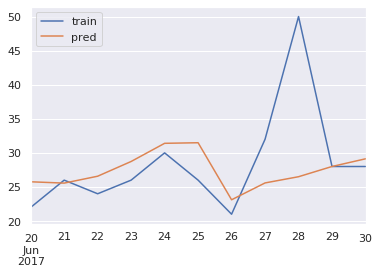

In [40]:
#traindata predict
pred = arimax.predict(tr_start,tr_end,exog = exog_train)[1:]
pd.DataFrame({'train':tra['2017-06-20':'2017-06-30'],
              'pred':pred['2017-06-20':'2017-06-30']}).plot();plt.show()

# Make featrues2

We make a new featrue and added.

In [41]:
#outlier etc...
buf['outlier_flag']=0
buf.loc[buf.index == '2017-06-28','outlier_flag']=1

In [42]:
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
tra = buf['sales'][tr_start:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()
exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end].dropna()
exog_test = buf.drop(['id','store','item','sales'],axis = 1)[te_start:te_end].dropna()

In [43]:
arimax_2 = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
arimax_2.summary()

C:\Users\magic\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1004
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -2942.164
Date:                Wed, 31 Jul 2019   AIC                           5960.327
Time:                        11:14:25   BIC                           6146.631
Sample:                    01-01-2015   HQIC                          6031.153
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
month-1              -4.3158      1.074     -4.017      0.000      -6.422      -2.210
month-2              -3.4289      1.045     -3.280      0.001      -5.478      -1.380
month-3              -2.5198      0.926     -2.721      0.007      -4.335      -0.705
month-4              -0.1319      0.829     -0.159      0.874      -1.757       1.493
month-5               0.4245      0.905      0.469      0.639      -1.350       2.198
month-6               1.6367      0.975      1.678      0.093      -0.275       3.548
month-7               3.6095      1.024      3.526      0.000       1.603       5.616
month-8               1.5351      0.905      1.697      0.090      -0.238       3.308
month-9               2.7012      0.826      3.270      0.001       1.082       4.320
month-10              2.1474      0.980      2.192      0.028       0.227       4.068
month-11              2.2996      1.065      2.160      0.031       0.213       4.387
month-12             -3.9577      1.075     -3.680      0.000      -6.065      -1.850
dayofweek-0          -3.5299      0.448     -7.879      0.000      -4.408      -2.652
dayofweek-1          -1.1505      0.396     -2.907      0.004      -1.926      -0.375
dayofweek-2          -0.4756      0.376     -1.266      0.206      -1.212       0.261
dayofweek-3           0.1363      0.380      0.359      0.720      -0.608       0.881
dayofweek-4           1.9144      0.368      5.199      0.000       1.193       2.636
dayofweek-5           1.4123      0.287      4.924      0.000       0.850       1.974
dayofweek-6           1.6928      0.315      5.370      0.000       1.075       2.311
weekend               3.1051      0.230     13.479      0.000       2.654       3.557
sales_shifted_728     0.0212      0.035      0.604      0.546      -0.048       0.090
sales_shifted_364     0.0429      0.034      1.275      0.202      -0.023       0.109
outlier_flag         20.5119      6.249      3.282      0.001       8.264      32.760
ar.L1                -0.5473      1.022     -0.535      0.592      -2.551       1.456
ar.L2                 0.2554      0.954      0.268      0.789      -1.614       2.125
ar.L3                 0.1986      0.918      0.216      0.829      -1.600       1.997
ar.L4                 0.1141      0.631      0.181      0.857      -1.123       1.351
ar.L5                -0.1555      0.479     -0.325      0.745      -1.094       0.783
ar.L6                -0.3445      0.375     -0.919      0.358      -1.079       0.390
ar.L7                -0.0306      0.075     -0.409      0.683      -0.178       0.116
ma.L1                -0.4145      1.021     -0.406      0.685      -2.415       1.586
ma.L2                -0.8025      0.876     -0.916      0.360      -2.519       0.914
ma.L3                 0.0384      0.824      0.047      0.963      -1.577       1.654
ma.L4                 0.0868      0.673      0.129      0.897      -1.233       1.406
ma.L5                 0.3368      0.643      0.524      0.6

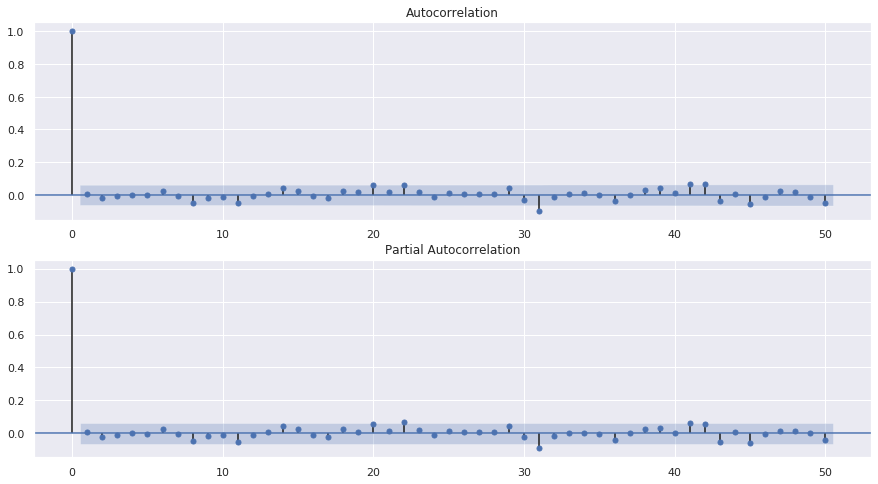

In [44]:
res = arimax_2.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error
pred = arimax_2.predict(tr_end,te_end,exog = exog_test)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX model MSE:24.08593432204018


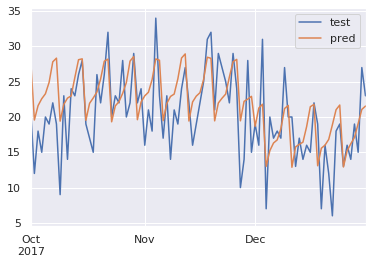

In [46]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()

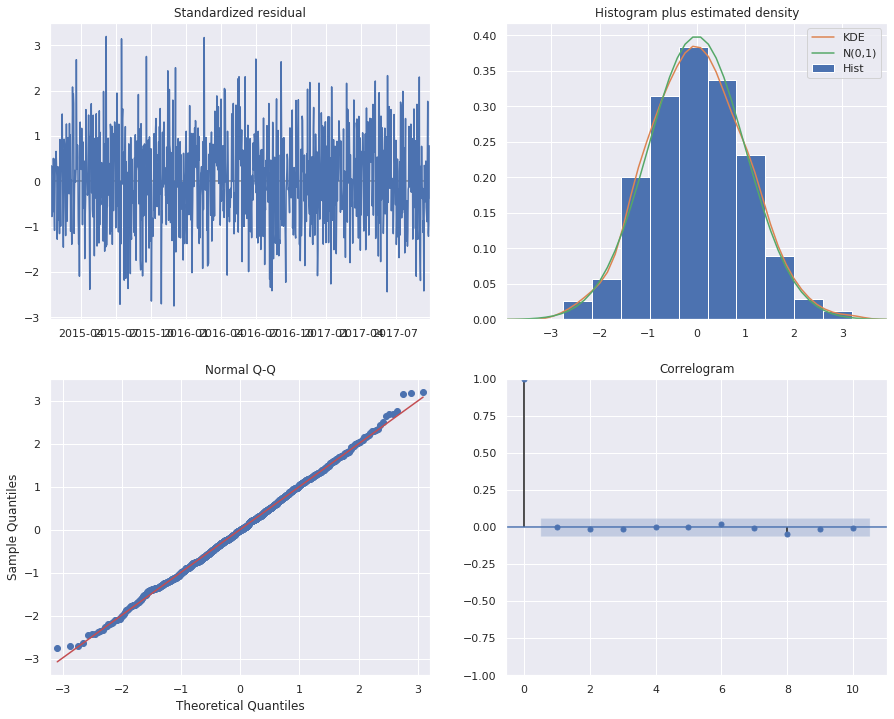

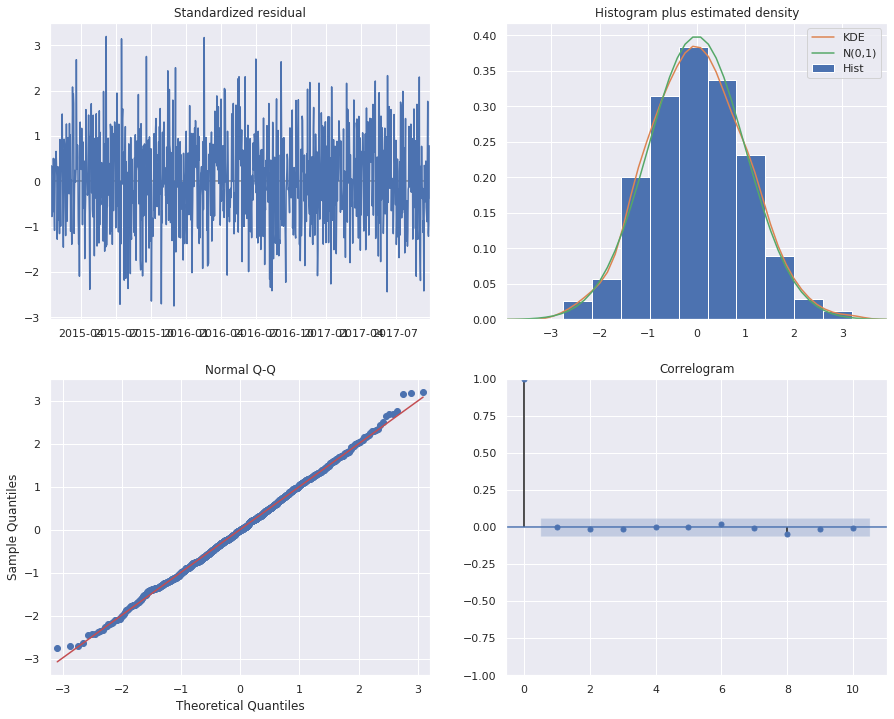

In [47]:
arimax_2.plot_diagnostics(figsize=(15, 12))

The histgram looks like still skew, but Jarque-Bera test's Prob is over 0.05.  
It means that this model's resid is following a normal distribution.    

An added featrue was useless to grow up predict accuracy.  
but, we were able to make a better model.

# Search best parameters

We can search best parameters of SARIMAX on this code.

import itertools
from sklearn.metrics import mean_squared_error

p = q = range(7,8)
pdq = list(itertools.product(p, [1], q))
sp = sq = range(1,8)#range(0,1) <- ARIMAX
seasonal_pdq = list(itertools.product(sp, [0,1], sq,[1]))#rlist(itertools.product(sp, [0], sq,[0]))<- ARIMAX

params = []
params_s = []
aics = []
mses = []
cnt = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:

        try:
            mod = sm.tsa.statespace.SARIMAX(tra,
                                            order=param,
                                            exog = exog_train,
                                            seasonal_order=param_seasonal,
                                            freq='D',
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            pred = results.get_prediction(start = pd.to_datetime(tr_end),
                                      end = pd.to_datetime(te_end),exog=exog_test)

            params.append(param)
            params_s.append(param_seasonal)
            aics.append(results.aic)
            mses.append(mean_squared_error(tes,pred.predicted_mean[1:]))


            #if cnt % 8 == 0:
            print('SARIMAX{}x{} - AIC:{} - MSE:{}'.format(param,
                                                            param_seasonal,
                                                            results.aic,
                                                        mses[-1]))
                #cnt += 1

        except:
            continue

min_ind = aics.index(min(aics))
bestparam = (params[min_ind],params_s[min_ind])
print('best_param_aic:',bestparam,' aic:',min(aics))
min_ind = mses.index(min(mses))
bestparam = (params[min_ind],params_s[min_ind])
print('best_param_mse:',bestparam,' mse:',min(mses))

print('Finish!!')

# Submit Prediction

In [48]:
train = pd.read_csv('../input/train.csv' ,parse_dates=['date'],index_col='date')
test = pd.read_csv('../input/test.csv', parse_dates=['date'],index_col='date')
df = pd.concat([train,test],sort=True)
sample = pd.read_csv('../input/sample_submission.csv')

FileNotFoundError: [Errno 2] File b'../input/train.csv' does not exist: b'../input/train.csv'

In [ ]:
#month one hot encoding
df['month'] = df.index.month
month_dummies = pd.get_dummies(df['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
df = pd.concat([df, month_dummies], axis=1, join_axes=[df.index]).drop(['month'],axis=1)
#dayofweek one hot encoding
df['dayofweek'] = df.index.weekday
week_dummies = pd.get_dummies(df['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
df = pd.concat([df, week_dummies], axis=1, join_axes=[df.index]).drop(['dayofweek'],axis=1)
#Satday,Sunday
df['weekend'] = (df.index.dayofweek>4).astype(int)#Satday,Sunday

#shifts
shifts = [364,728]
for s in shifts:
    df['store_item_shifted-'+str(s)] = df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(s))

In [ ]:
results = []
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
for i in range(1,51):
    for s in range(1,11):
        buf = df[(df.item==i)&(df.store==s)].copy()
        #buf['sales_shifted_728'] = buf.sales.shift(728)
        #buf['sales_shifted_364'] = buf.sales.shift(364)
        #target_exog = buf[~buf.id.isnull()].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        target_exog = buf[te_start:].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        
        #train_test_split
        tra = buf['sales'][tr_start:tr_end]#.dropna()
        tes = buf['sales'][te_start:te_end]#.dropna()
        exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end]#.dropna()
        #exog_test = buf.drop(['id','store','item','sales'],axis = 1)[te_start:te_end]#.dropna()
        
        #fitting
        mod = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                       enforce_stationarity=False, enforce_invertibility=False).fit()
        pred = mod.get_prediction(tr_end,'2018-03-31',exog =target_exog)#pd.concat([exog_test,target_exog]))
        results.extend(pred.predicted_mean['2018-01-01':])
        print('item:',i,'store:',s,'Finished.')

In [ ]:
sample['sales'] = results
sample.to_csv('submission.csv',index=False)